In this post, I will show you how to develop and assess a fake news classifier using Keras.

# 1. Acquire Training Data

We will first import the data set for this project. Here is the [source](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) of the data set. The following url contains the training data set.

In [1]:
import pandas as pd

train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
train_data = pd.read_csv(train_url)
train_data.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


Note that each row of the data corresponds to an article. The `title` column gives the title of the article, whereas the `text` column gives the full article text. The final column, `fake`, is `0` if the article is real news and `1` if the article is fake news.

# 2. Make a Dataset

Next, we will implement a function called `make_dataset` to clean our training data and prepare it for training. Here's what the function looks like:

In [2]:
import numpy as np
import keras
from keras import layers
from keras import ops
import tensorflow as tf
from nltk.corpus import stopwords

def make_dataset(train_data):
  """ changes the text of training data to lowercase,
      removes stopwords from text and title, and returns
      a tf.data.Dataset with two inputs and one output """

  # converts text to lowercase
  train_data["text"] = train_data["text"].str.lower()

  # removes stopwords from title and text
  stop = stopwords.words('english') # loading english stop words
  train_data["title"] = train_data["title"].apply(
      lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  train_data["text"] = train_data["text"].apply(
      lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  dataset = tf.data.Dataset.from_tensor_slices((
      {"title": train_data["title"].values, # (title, text) as input
       "text": train_data["text"].values},
      train_data["fake"].values   # fake column as output
  ))

  # batching dataset (allows model to train on chunks rather than rows)
  dataset = dataset.batch(100)

  return dataset

In [3]:
dataset = make_dataset(train_data)
dataset

<_BatchDataset element_spec=({'title': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'text': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Next, we will split 20% of our `dataset` to use for validation. Notice that we are using 45 batches for our validation data.

In [4]:
dataset = dataset.shuffle(buffer_size = len(dataset),
                       reshuffle_each_iteration = False)

train_size = int(0.8*len(dataset))
val_size = int(0.2*len(dataset))

train = dataset.take(train_size)
val   = dataset.skip(train_size).take(val_size)

len(train), len(val)

(180, 45)

We'll now determine the base rate for our dataset by examining the labels on the training set. As we can see, the base rate is roughly 53%, which is what one might expect.

In [5]:
import pandas as pd

def calculate_base_rate(train_data):
    # Count the number of instances of each class (1 and 0)
    class_counts = train_data["fake"].value_counts()

    # Calculate the base rate by finding the max count divided by
    # total number of samples
    base_rate = class_counts.max() / class_counts.sum()

    return base_rate

# Calculate and print the base rate
base_rate = calculate_base_rate(train_data)
print("Base Rate:", base_rate)

Base Rate: 0.522963160942581


Finally, we will prepare a text vectorization layer for our tf model.

In [6]:
from tensorflow.keras.layers import TextVectorization
import re
import string

#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

## 3. Create Models

We will create three Keras model to offer a perspective the following question:

When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

For the first model, we will use **only the article title** as input.

In [32]:
from tensorflow.keras.losses import BinaryCrossentropy

train_data = train.map(lambda x, y: x["title"])
title_vectorize_layer.adapt(train_data)

# input layer
title_input = keras.Input(shape=(1,), dtype="string", name="title")

# text processing layers
title_features = title_vectorize_layer(title_input)
title_features = layers.Embedding(size_vocabulary, 3, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

# output layer
output = layers.Dense(1, activation='sigmoid')(title_features)


# model compilation (need to do this before training)
model1 = keras.Model(inputs=title_input, outputs=output)
model1.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=['accuracy'])

model1.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 3)              │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 500, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_12          │ (None, 3)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

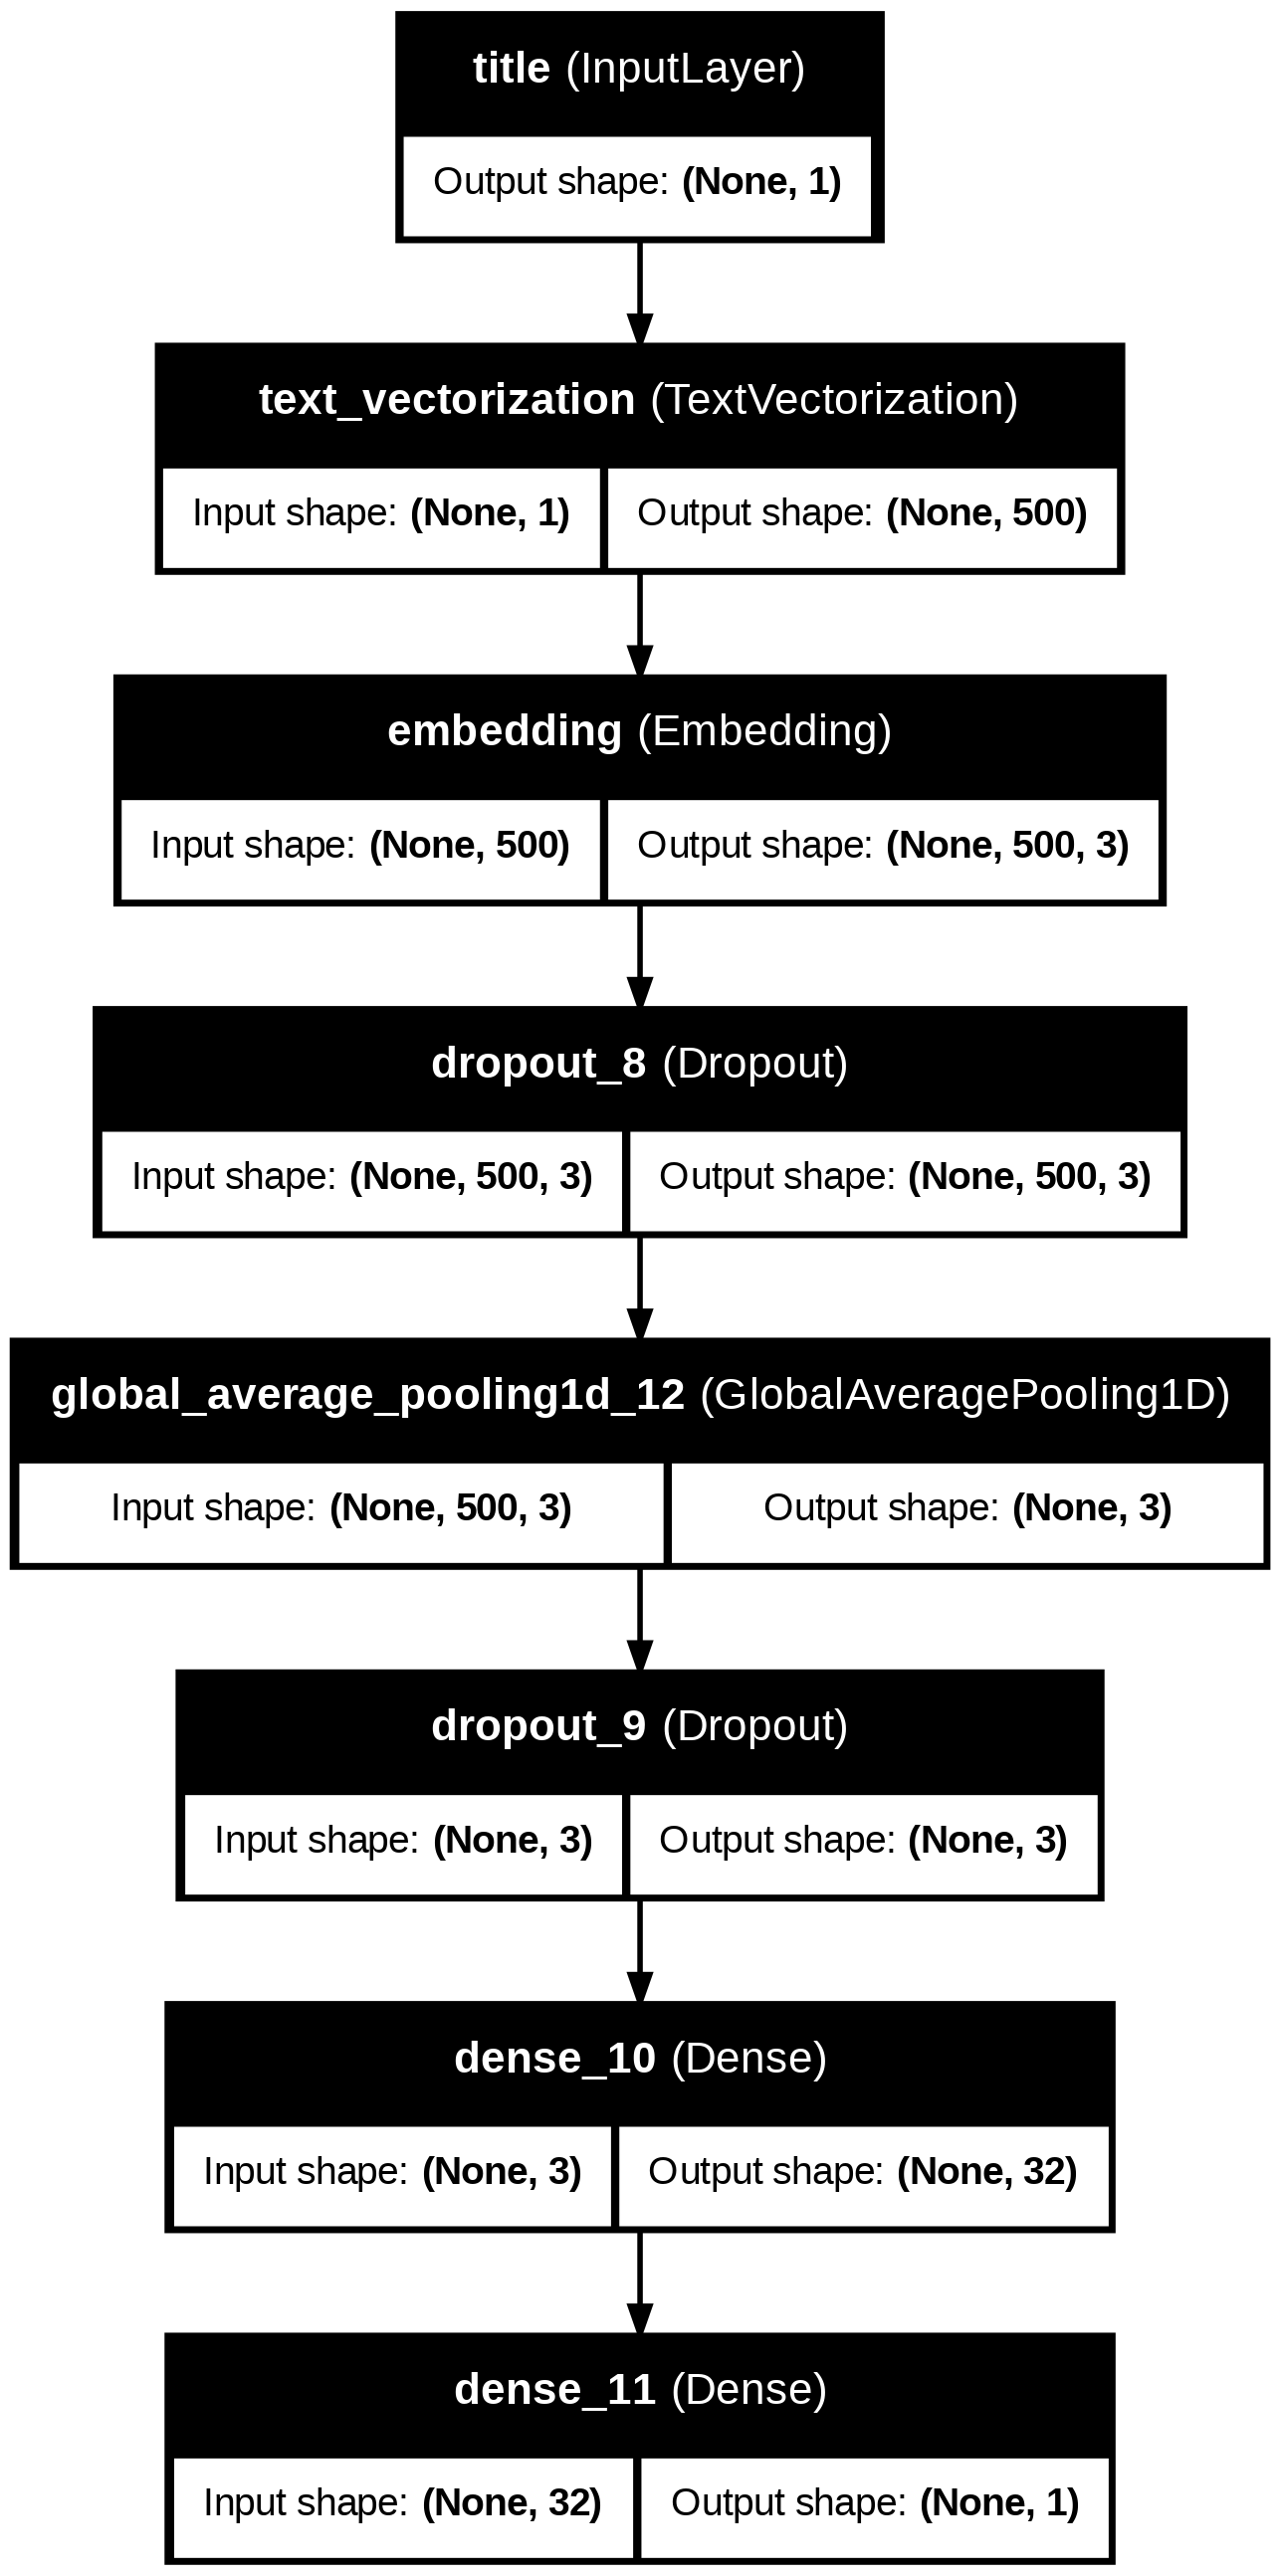

In [33]:
# to visualize the model

from keras import utils
utils.plot_model(model1, "output_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

Now we train our model.

In [34]:
# implement callback for early stopping to prevent overfitting
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train model
history = model1.fit(train,
                    validation_data=val,
                    epochs = 50,
                    callbacks=[callback],
                    verbose = True)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5263 - loss: 0.6890 - val_accuracy: 0.8038 - val_loss: 0.6404
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8175 - loss: 0.5799 - val_accuracy: 0.9451 - val_loss: 0.3571
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9034 - loss: 0.3341 - val_accuracy: 0.9218 - val_loss: 0.2310
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9200 - loss: 0.2399 - val_accuracy: 0.9253 - val_loss: 0.1896
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9359 - loss: 0.1982 - val_accuracy: 0.9187 - val_loss: 0.1785
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9346 - loss: 0.1861 - val_accuracy: 0.9178 - val_loss: 0.1721
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9419 - loss: 0.1732 - val_accuracy: 0.9304 - val_loss: 0.1544
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9456 - loss: 0.1605 - val_accu

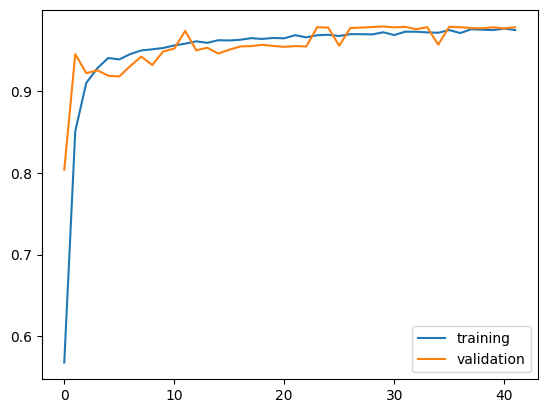

In [35]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

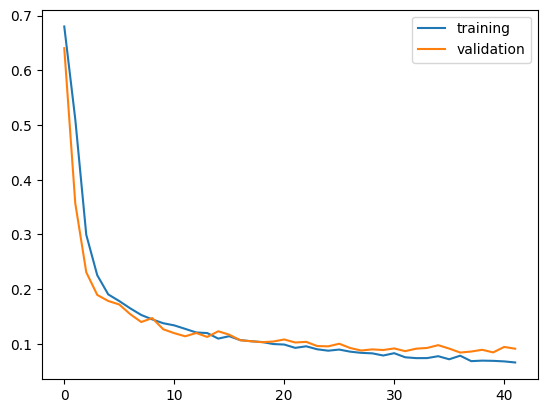

In [36]:
plt.plot(history.history["loss"],label='training')
plt.plot(history.history["val_loss"],label='validation')
plt.legend()

It appears that `model1`'s accuracy ranges between 96% and 97.5%.



For the second model, we will use **only the article text** as input. Once again, we'll compile and then train the model.

In [37]:
train_texts = train.map(lambda x, y: x['text'])
text_vectorize_layer.adapt(train_texts)

# input Layer
text_input = keras.Input(shape=(1,), dtype="string", name="text")

# text processing layers
text_features = text_vectorize_layer(text_input)
text_features = layers.Embedding(size_vocabulary, 3, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

# output layer
output = layers.Dense(1, activation='sigmoid')(text_features)

# Model Compilation
model2 = keras.Model(inputs=text_input, outputs=output)
model2.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=['accuracy'])
model2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 3)              │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 500, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_13          │ (None, 3)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

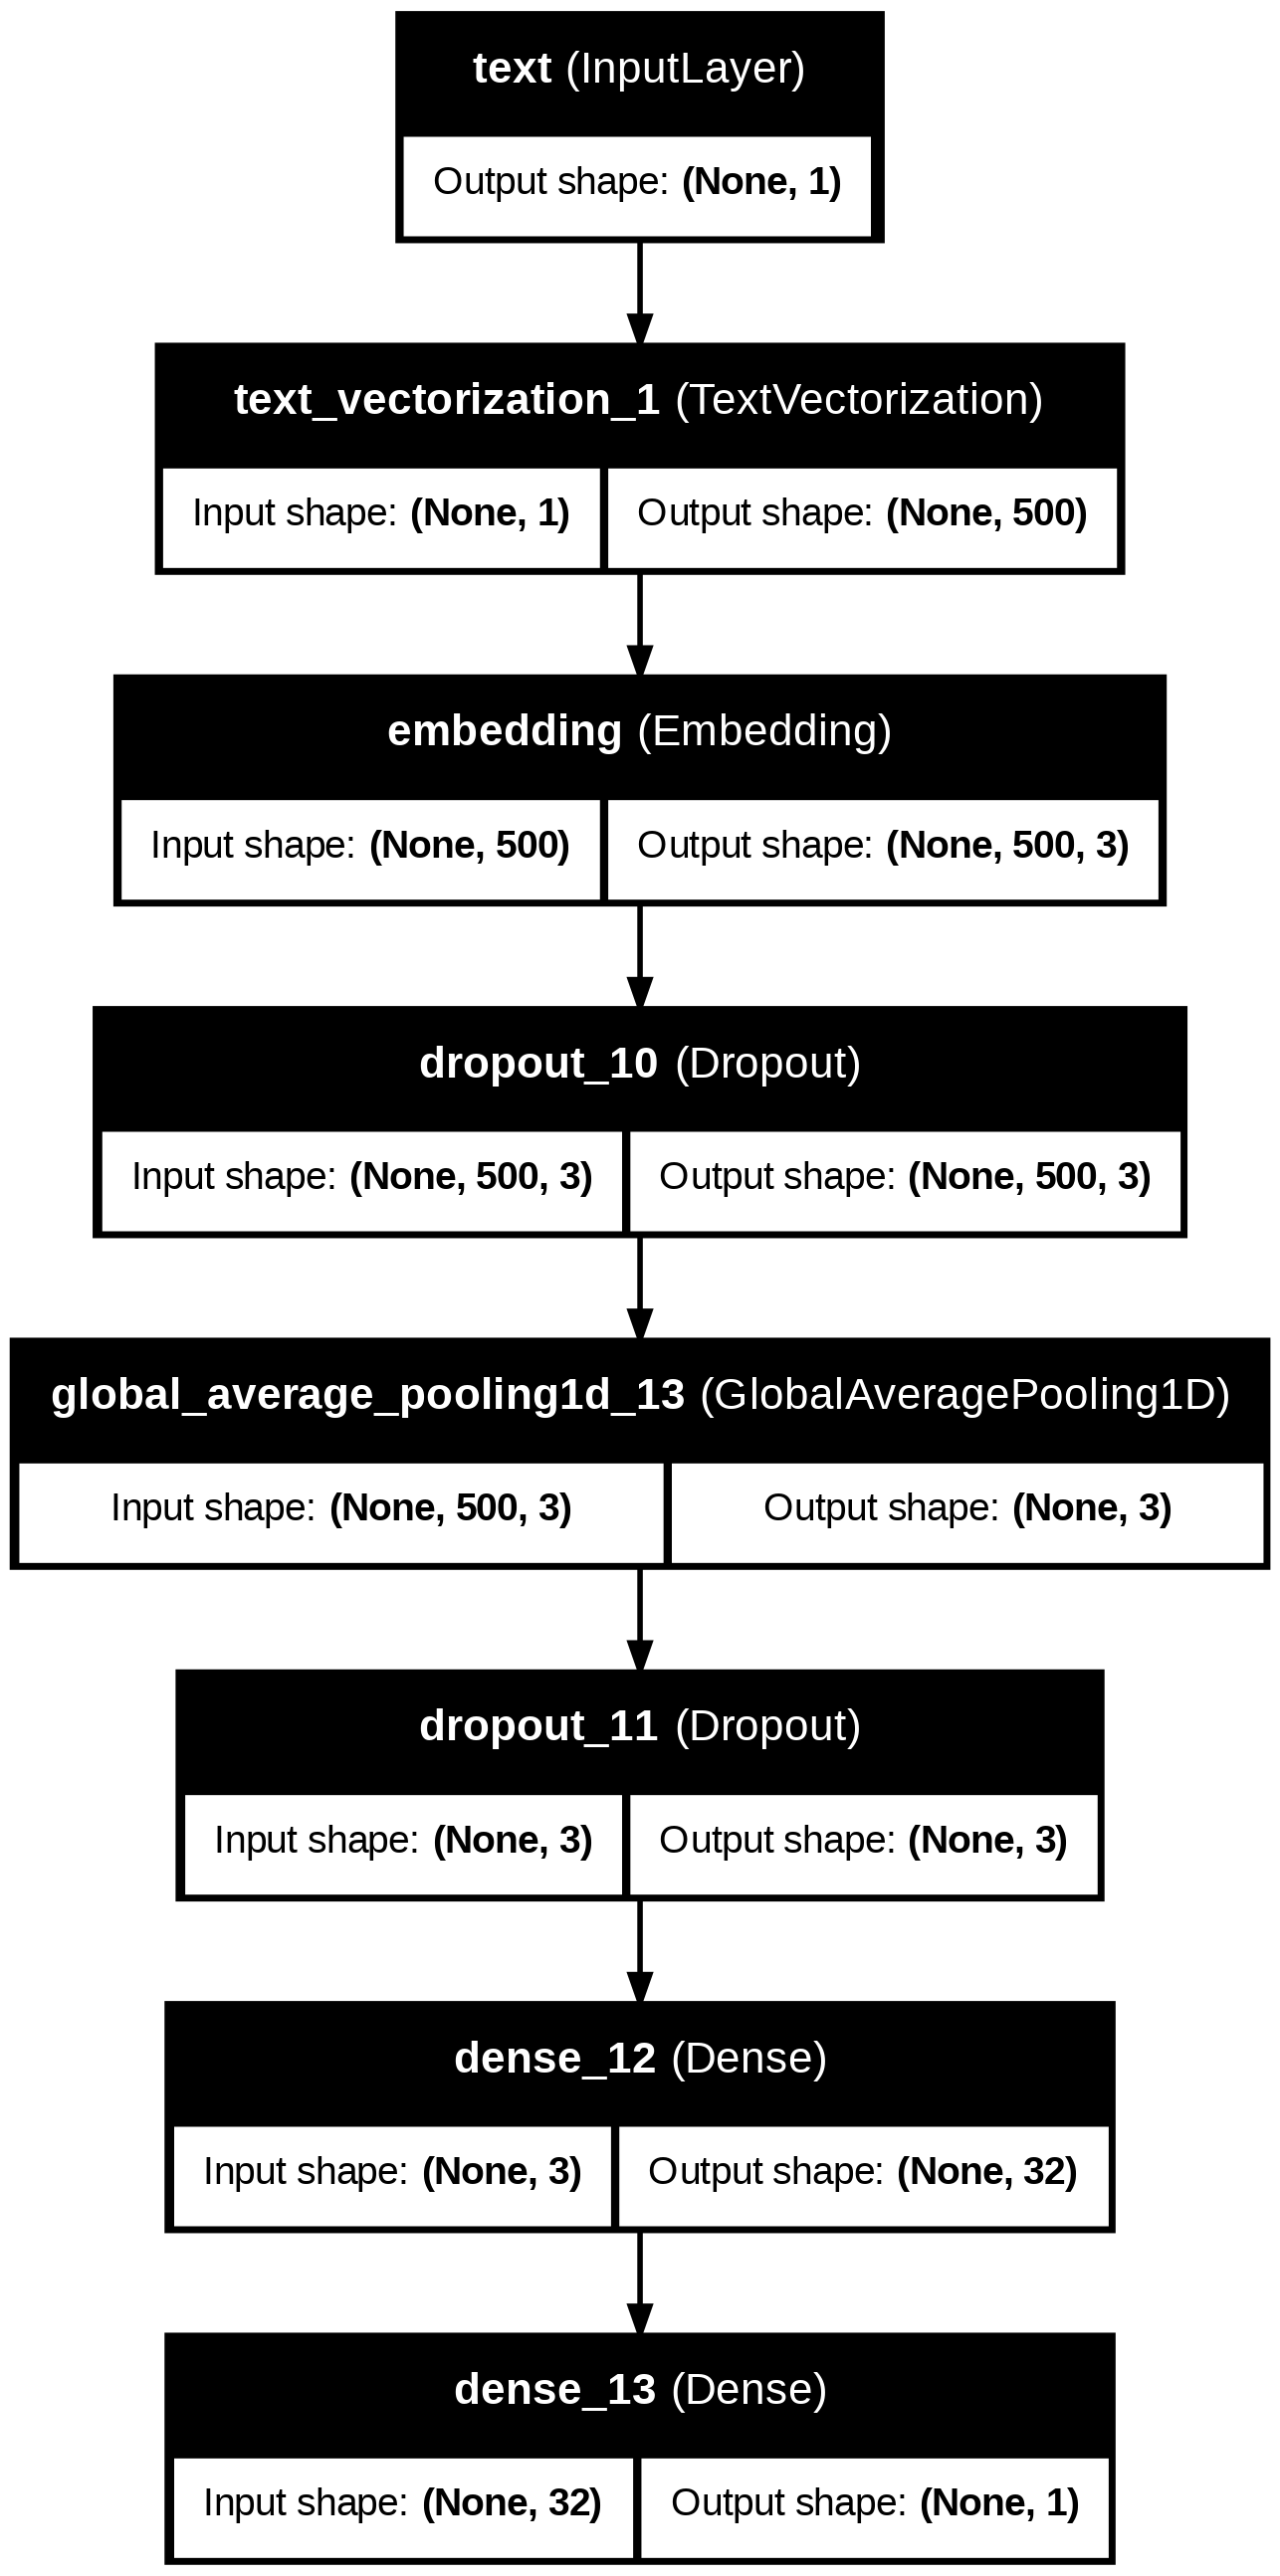

In [38]:
# to visualize the model

utils.plot_model(model2, "output_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

In [39]:
# implement callback for early stopping to prevent overfitting
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train model
history = model2.fit(train,
                    validation_data=val,
                    epochs = 50,
                    callbacks=[callback],
                    verbose = True)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5335 - loss: 0.6873 - val_accuracy: 0.8627 - val_loss: 0.6162
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.8523 - loss: 0.5490 - val_accuracy: 0.9489 - val_loss: 0.3287
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9127 - loss: 0.3132 - val_accuracy: 0.9229 - val_loss: 0.2216
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9291 - loss: 0.2258 - val_accuracy: 0.9189 - val_loss: 0.1876
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9337 - loss: 0.1943 - val_accuracy: 0.9260 - val_loss: 0.1683
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9443 - loss: 0.1668 - val_accuracy: 0.9358 - val_loss: 0.1487
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9461 - loss: 0.1542 - val_accuracy: 0.9356 - val_loss: 0.1424
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9473 - loss: 0.1461 - val_accu

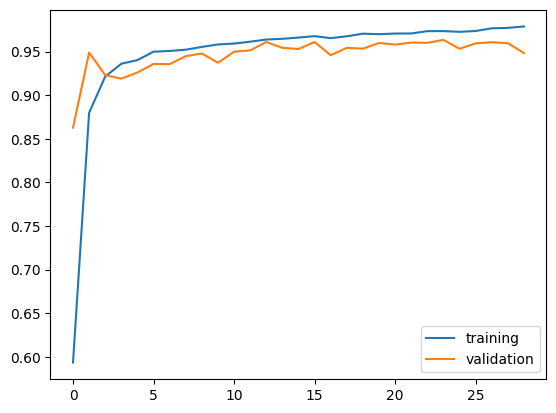

In [40]:
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

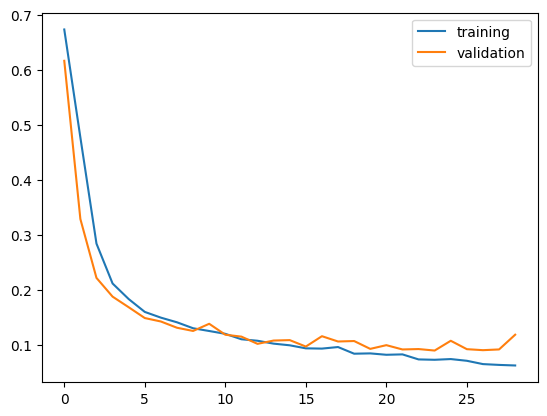

In [41]:
plt.plot(history.history["loss"],label='training')
plt.plot(history.history["val_loss"],label='validation')
plt.legend()

It appears that `model2`'s accuracy ranges between 96.5% and 97.5%, which is a slight improvement compared to `model1`.

For the third model, we will use **both the article title and the article text** as input.

In [44]:
from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, GlobalAveragePooling1D, Dense, Input, concatenate

train_data = train.map(lambda x, y: (x["title"], x["text"]))
train_titles, train_texts = zip(*train_data)

shared_embedding = Embedding(size_vocabulary, 3, name = "embedding")

title_input = Input(shape=(1,), dtype=tf.string, name="title")
title_vectorized = title_vectorize_layer(title_input)
title_embedded = shared_embedding(title_vectorized)
title_processed = GlobalAveragePooling1D()(title_embedded)

text_input = Input(shape=(1,), dtype=tf.string, name="text")
text_vectorized = text_vectorize_layer(text_input)
text_embedded = shared_embedding(text_vectorized)
text_processed = GlobalAveragePooling1D()(text_embedded)

combined_features = concatenate([title_processed, text_processed])
output = Dense(1, activation='sigmoid')(combined_features)

model3 = keras.Model(inputs=[title_input, text_input], outputs=output)
model3.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=['accuracy'])

model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 500)            │              0 │ title[0][0]            │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 500)            │              0 │ text[0][0]             │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 3)         │          6,000 │ text_vectorization[7]… │
│                           │                        │                │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 3)              │              0 │ embedding[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 3)              │              0 │ embedding[1][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 6)              │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │              7 │ concatenate_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,007 (23.46 KB)

 Trainable params: 6,007 (23.46 KB)

 Non-trainable params: 0 (0.00 B)

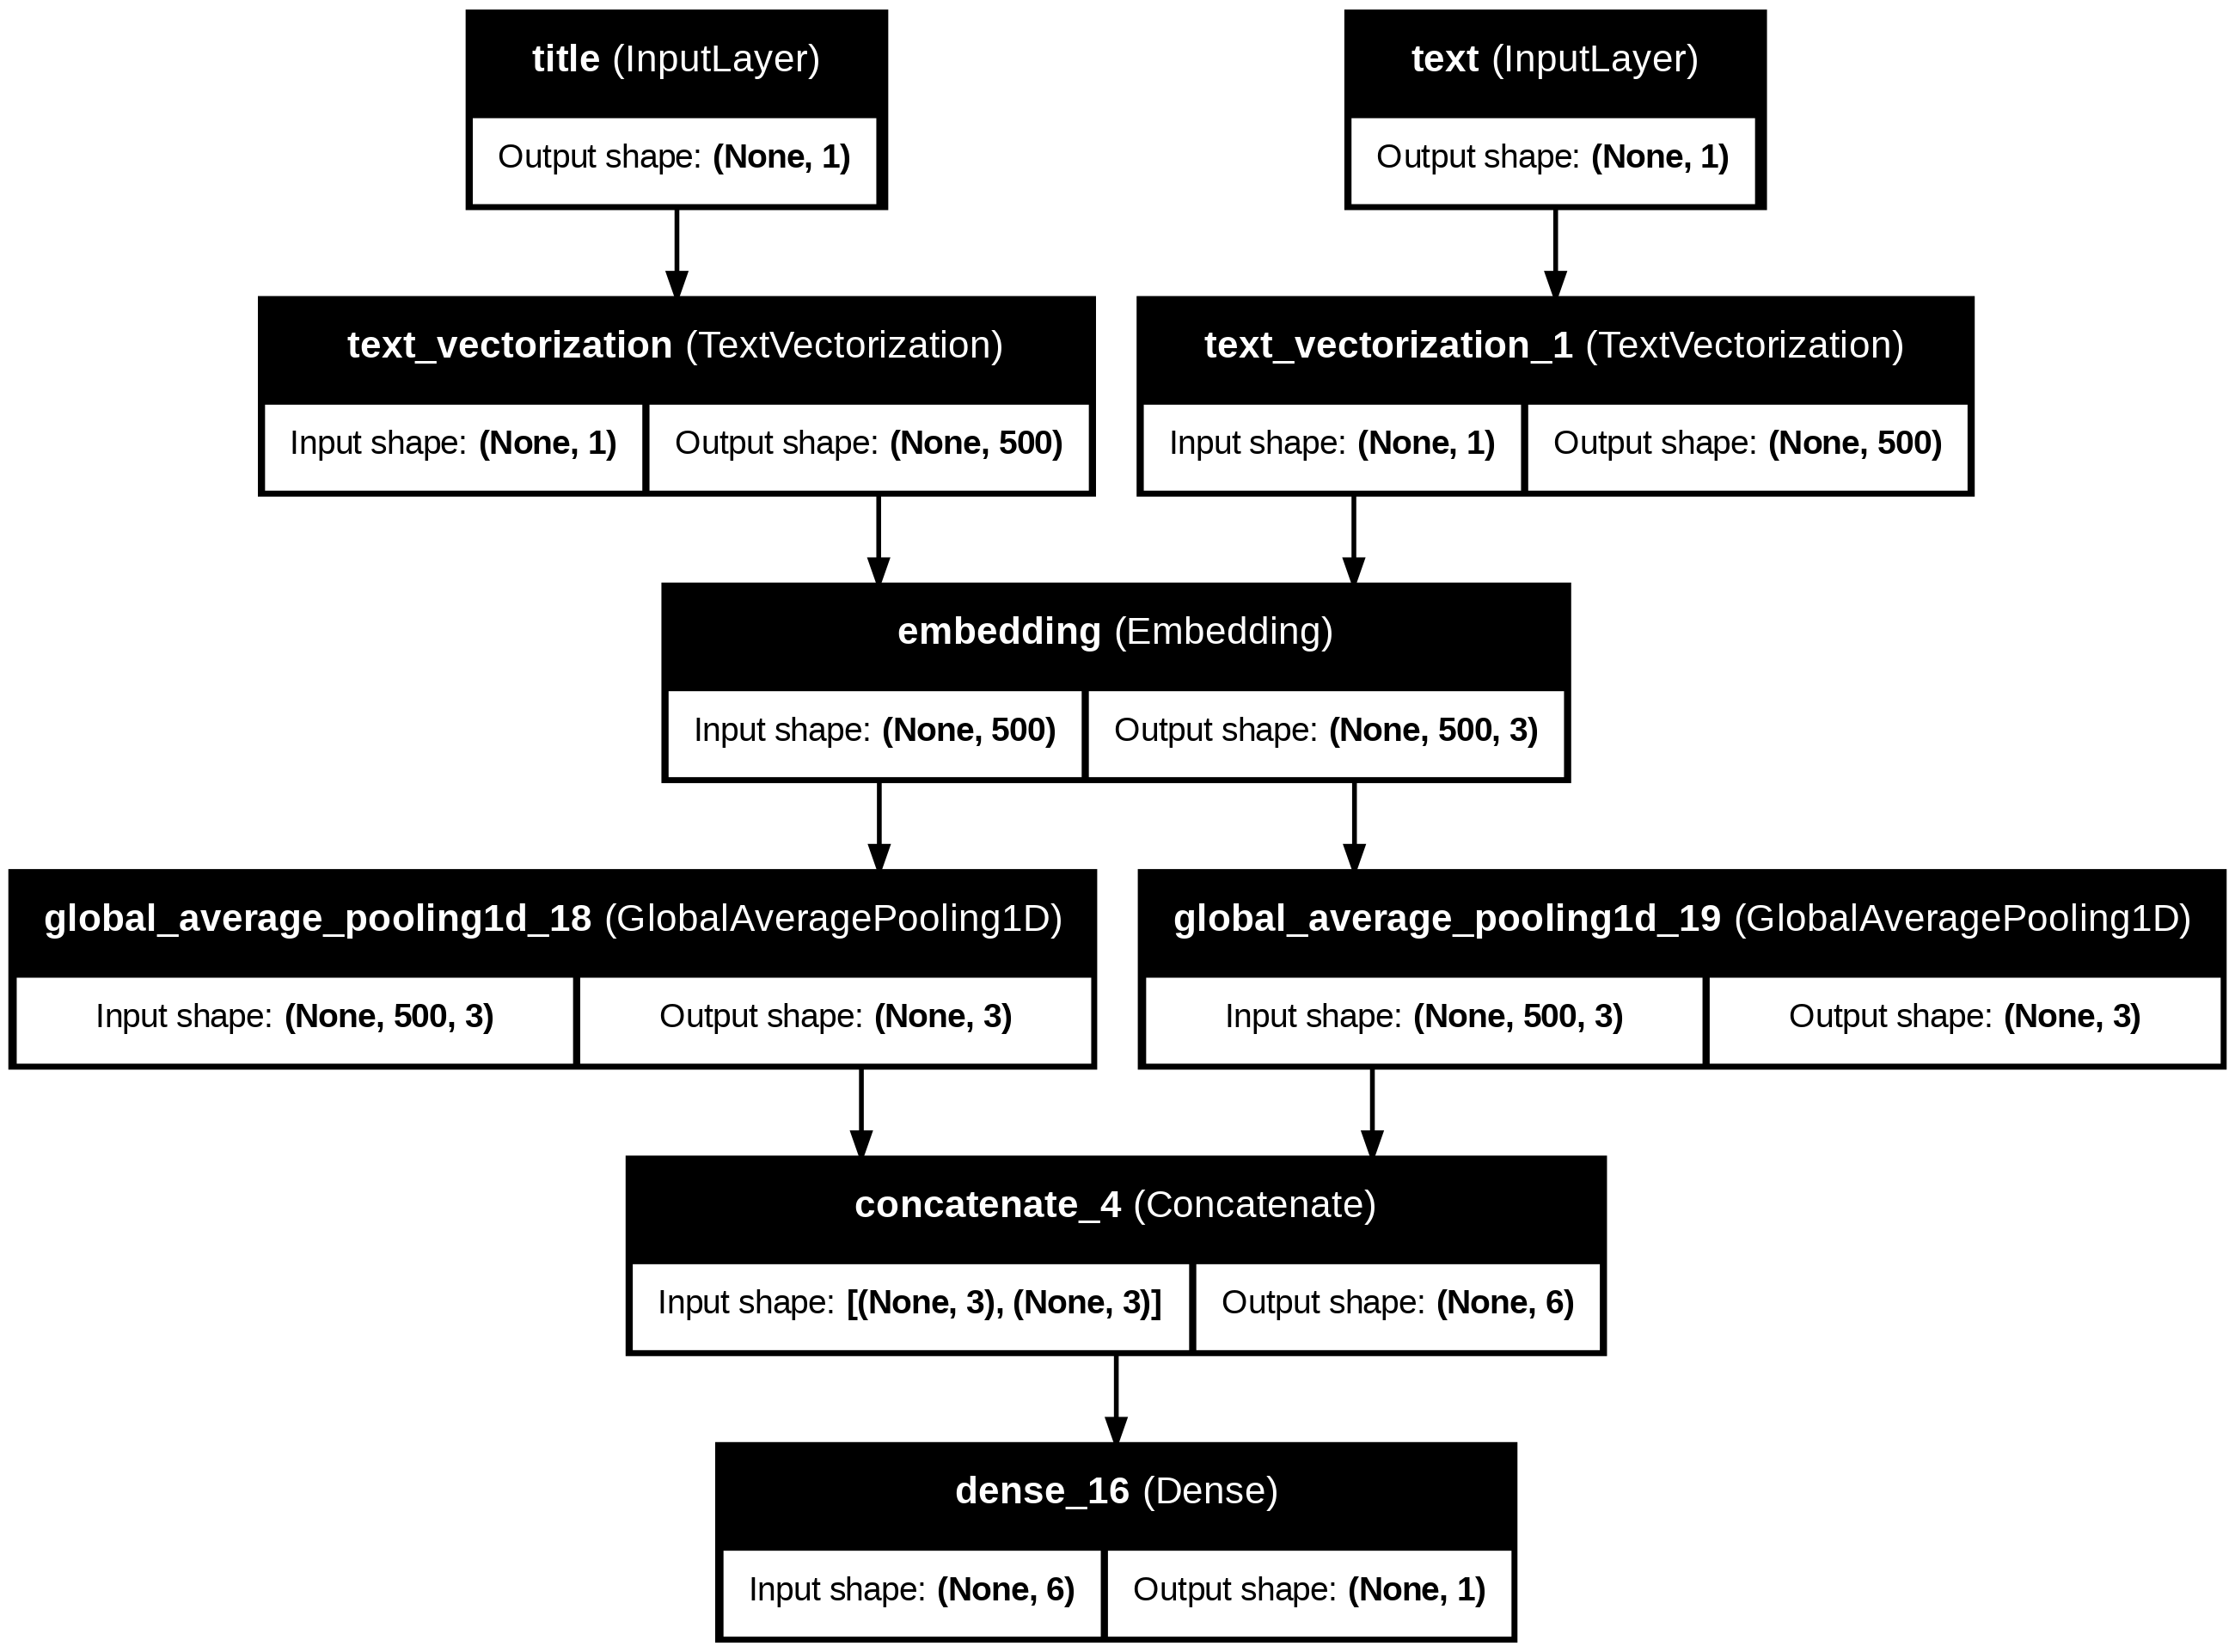

In [46]:
utils.plot_model(model3, "output_filename.png",
                       show_shapes=True,
                       show_layer_names=True)

In [45]:
# implement callback for early stopping to prevent overfitting
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train model
history = model3.fit(train,
                    validation_data=val,
                    epochs = 50,
                    callbacks=[callback],
                    verbose = True)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5798 - loss: 0.6851 - val_accuracy: 0.6607 - val_loss: 0.6560
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6959 - loss: 0.6448 - val_accuracy: 0.7358 - val_loss: 0.6053
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7639 - loss: 0.5922 - val_accuracy: 0.8273 - val_loss: 0.5465
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8506 - loss: 0.5326 - val_accuracy: 0.9038 - val_loss: 0.4869
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9067 - loss: 0.4742 - val_accuracy: 0.9291 - val_loss: 0.4338
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9252 - loss: 0.4234 - val_accuracy: 0.9378 - val_loss: 0.3895
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9342 - loss: 0.3814 - val_accuracy: 0.9424 - val_loss: 0.3534
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9386 - loss: 0.3473 - val_accu

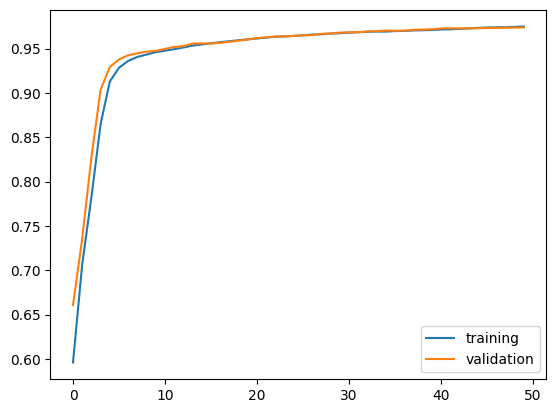

In [47]:
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

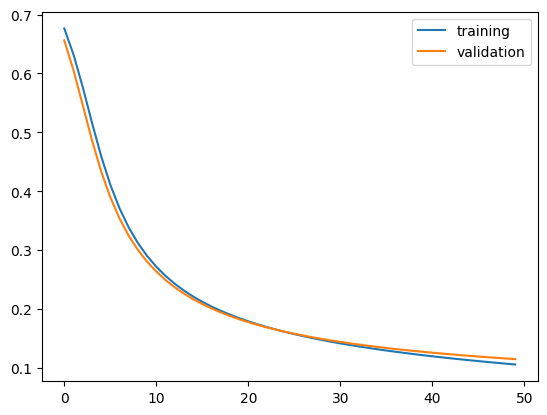

In [48]:
plt.plot(history.history["loss"],label='training')
plt.plot(history.history["val_loss"],label='validation')
plt.legend()

Compared to the previous two models, `model3` appears to perform the best, because its accuracy ranges between 97% and 97.31% towards the last 10 epochs. Though it's not as high as the other two models, `model3` is able to consistently score at least 97% validation accuracy. Whereas the other two models often fluctuate between 96% and 97%.

## 4. Model Evaluation

We will now use `model3` to test my model performance on unseen data.

In [51]:
# load test data
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_data = pd.read_csv(train_url)
test_data.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


In [53]:
test = make_dataset(test_data)
loss, accuracy = model3.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9737 - loss: 0.1090
Test Loss: 0.10588612407445908
Test Accuracy: 0.9754109382629395


It appears that `model3` managed to get a test accuracy of 97.5%, which is great!

## 5. Embedding Visualization

Let's visualize and comment on the *embedding* that `model3` learned.

In [62]:
# to display plotly plots on quarto
import plotly.io as pio
pio.renderers.default="iframe"

In [63]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

weights = model3.get_layer('embedding').get_weights()[0]

vocab = title_vectorize_layer.get_vocabulary()

pca = PCA(n_components=2)
reduced_weights = pca.fit_transform(weights)
embedding_df = pd.DataFrame({
    'word': vocab,
    'x0': reduced_weights[:, 0],
    'x1': reduced_weights[:, 1]
})

fig = px.scatter(embedding_df,
                 x="x0",
                 y="x1",
                 hover_name="word",  # shows the word on hover
                 title="2D PCA of Word Embeddings",
                 width=800,
                 height=600)
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In the graph above, the embedding of the words "Wednesday", "Thursday", "Monday", "Tueday", and "Friday" appear to be clustered together but not inside the central cluster. Moreover, their x1 values appear to be close to 0. Whereas their x0 values appear to range between -16 and -19. Since they are clustered outside of the central cluster, this means that these words likely do not help one differentiate between fake and real news.

Moreover, the fact that they are clustered together also makes sense, because all of them are days of the week.